In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mat

#import psycopg2

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import scipy.stats
from statistics import mean 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import chart_studio
import plotly.io as pio

In [15]:
import sys  

sys.path.insert(0, '/Users/GuntherUlvanget/country_life/price_consult')

import boot_strap_sample
import warnings
warnings.filterwarnings('ignore')






def clean_CL_UPC(df):
	#to match items in SPINS data, CL starts with Leading zero

	df["UPC"] = df["UPC"].apply(str)
	df["UPC"] = df["UPC"].apply(lambda x : x[:-1])
	df["UPC"] = df["UPC"].apply(lambda x : "0" + x)
	column_name = "UPC"
	first = df.pop(column_name)
	df.insert(0, column_name, first)
	df["MSRP$"] = df["MSRP$"].str.lstrip('$')
	df["WSP$"] = df["WSP$"].str.lstrip('$')
	df["MSRP$"] = df["MSRP$"].apply(float)
	df["WSP$"] = df["WSP$"].apply(float)
	df["Unit Size"] = df["Unit Size"].apply(int)
    
    
def process_data(file_path_todata):
    df = pd.read_csv(file_path_todata, 
        sep = ",", 
        na_values = "-",
       usecols= [  'Geography', 'Item_UPC', 'Brand', 'Subcategory',
           'AGE', 'FORM', 'FUNCTIONAL_INGREDIENT', 'FLAVOR', 'HEALTH_FOCUS',
        'Group', 'SIZE', 'Dollars', 'Dollars_Yago', 'Units', 'Units_Yago', 'Dollars_SPP', 'ARP',
        'ARP_Yago',  'Base_ARP',
        'Base_ARP_Yago']
         )

    df.dropna(axis = 0, how = "all", inplace=True)
    return df

def clean_spins_upc(df):
	#take in a dataframe, expand the number of columns into a temp
	#datafram
	temp = df["Item_UPC"].str.rsplit(" ", n=1, expand = True)
	#add columns  to main dataframe from Temp
	df.insert(0, "UPC", temp[1])
	df.insert(1, "Item", temp[0])

	#drop original combined column
	df.drop(columns= ["Item_UPC"], inplace=True)
	#SPINS data adds a leading zero to UP and includes hypen. 
	#neither are needed for analysis.
	df["UPC"]= df["UPC"].apply(lambda x : x[1:] if x.startswith("0") else x)
	df["UPC"]=df["UPC"].apply(lambda x :x.replace('-', ''))
	col_names = df.columns
	for cols in col_names:
	    df[cols] = df[cols].apply(lambda x: x.lower() if type(x) == str else x)
        
def sku_selcetor_ingredient(FUNCTIONAL_INGREDIENT, df):
	'''Functional ingredient can be a shortened description like cal for calcium
	or mag for magnesium. this will select all Items that contain the string entered'''
	cl_df = df[df["Brand"].str.contains("country life")]
	temp_df = cl_df[cl_df["Item"].str.contains(FUNCTIONAL_INGREDIENT)]
	
	return temp_df


def sku_singleton(item_id,df, brand = "country life"):
    '''Select a single SKU to examine, item ID can be either full UPC or catalog ID
    df = the dataframe you are subsetting'''
    df = df[df["Brand"].str.contains(brand)]
    df = df[df["UPC"].str.contains(item_id)].reset_index()
    df.dropna(inplace = True)
    #df["ARP_percent_off_MSRP"] =  df["ARP"].apply(lambda x: (1-(x/get_MSRP("item_id")))*100)
    df.loc[:, "ARP_percent_off_MSRP"] =  df.loc[:,"ARP"].apply(lambda x: (1-(x/get_MSRP(item_id)))*100)
    #df['bins'] = pd.cut(df['ARP_percent_off_MSRP'],bins=[0,5,10,15,20,25,30,35,40], labels=["0-5%","5-10%","10-15%","15-20%","20-25%","25-30%", "30-35%","35-40"])
    df.loc[:,'bins'] = pd.cut(df['ARP_percent_off_MSRP'],bins=[0,5,10,15,20,25,30,35,40], labels=["0-5% off","5-10% 5-10% off","10-15% off","15-20% off","20-25% off","25-30% off", "30-35% off","35-40% off"])
    
    return df


def get_MSRP(item_id ):
	temp = cl_top_seller[cl_top_seller.loc[:,"UPC"].str.contains(item_id)].reset_index()
	return temp["MSRP$"][0]


def sub_set_metrics_of_interest(df, metric_to_use = ['ARP',"Base_ARP"]):
	return df.loc[df["Metric"].isin(metric_to_use)].reset_index()

def easy_melt(df):
	return df.melt(id_vars=["UPC", "Item","Geography",'Brand', 'Subcategory'], var_name = "Metric" , value_name='amount')

def get_discount_proportions(df):
    ''' Takes in a dataframe, returns a smaller dataframe'''
    group_by_df =df.groupby("bins").size()
    #groups are stored in the index, values in series
    #extract groups
    groups = pd.DataFrame(group_by_df).index
    final = group_by_df.to_frame().join(groups.to_frame())
    #rename column 0 for extracting data in pie chart
    final.rename(columns = {0:"count"}, inplace = True )
    return final

def subset_for_boxplots(df):
    metric_to_use = ['ARP',"Base_ARP"]
    df = df[df["Metric"].isin(metric_to_use)].reset_index()

    return df

def cl_box_plot(df):
    fig = px.box(df, x="Metric", y="amount", points="all", title = df["Item"][0])
    fig.add_trace(go.Scatter(x=['ARP', 'Base_ARP'], y=[get_MSRP(df.loc[0,"UPC"]),get_MSRP(df.loc[0,"UPC"])], mode="lines", name="MSRP"))
    fig.show()
    
def make_plots(df,pie_frame):
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "box"}, {"type": "pie"}]],
    )

    fig.add_trace(go.Box( x=df.Metric, 
                         y=df.amount, 
                         boxpoints ="all",
                         hovertext = df["Geography"],
                         jitter =0.5,
                         boxmean = True, 
                         showlegend=False,
                       # hovertemplate = 'Geography: $%{geography}'
                        ), 
                  row=1, col=1)
    #adds a line to reprsentMSRP
    fig.add_trace(go.Scatter(x=['ARP', 'Base_ARP'], y=[get_MSRP(df.loc[0,"UPC"]),get_MSRP(df.loc[0,"UPC"])],
                             mode="lines", name="MSRP", line=dict(color="#000000") ))
    
    #generates pie chart from calculated proportion data
    fig.add_trace(go.Pie(values=pie_frame["count"], labels =pie_frame["bins"], showlegend=True,
                         title_text ="Proportion MSRP Discounts"),
                  row=1, col=2)
    # Update xaxis properties
    fig.update_xaxes(title_text="Distribution of ARP vs Base ARP", row=1, col=1)
    #fig.update(title_text="Proportion of ARP as percentage discount",  row=1, col=2)

    fig.update_yaxes(title_text="Dollars", row=1, col=1)
    #fig.update_yaxes(title_text="Proportion of ARP as percentage discount",  row=1, col=2)

    #label the plot
    fig.update_layout(title_text=df["Item"][0], height=600)
    fig.update_layout(height=600, showlegend=True)

    fig.show()
    pio.write_html(fig, file=df["Item"][0]+'.html', auto_open=True)
  

  
def Average(lst): 
    return mean(lst) 

def single_product_analysis(item_id):
    single_sku_df = sku_singleton(("0"+str(item_id)),df)
    pie_frame = get_discount_proportions(single_sku_df)

    melted_df = easy_melt(single_sku_df)



    subset_df_forplot = subset_for_boxplots(melted_df)

    make_plots(subset_df_forplot, pie_frame)
    boot_strap_sample.plot_bootstrap_mean(single_sku_df["ARP"].to_numpy())
    boot_strap_sample.plot_bootstrap_median(single_sku_df["ARP"].to_numpy(), test_statistic=np.median)
    
def calculate_mean(item_id):
    single_sku_df = sku_singleton(("0"+str(item_id)),df)
    means, ci = boot_strap_sample.bootstrap_ci(single_sku_df["ARP"].to_numpy())
    return round(Average(means),2)



single_sku_df = sku_singleton(str(2474),df)
means, ci = boot_strap_sample.bootstrap_ci(single_sku_df["ARP"].to_numpy())
estimates = [calculate_mean(item) for item in items]


#cl_top_seller.loc[:,'Price in Marketplace'] = np.asarray(estimates)
#cl_top_seller.to_excel("Top Sellers with Price in Marketplace.xlsx", index = False)

In [ ]:
#round(Average(means),2)

In [4]:

cl_top_seller = pd.read_csv("/Users/GuntherUlvanget/country_life/country_life_spins/Country Life Top Seller's Price File.csv", sep = ",")
clean_CL_UPC(cl_top_seller)


df = pd.read_csv("/Users/GuntherUlvanget/country_life/country_life_spins/Retailer_Report_24 Weeks_7_12_2020.csv", 
                 sep = ",", na_values="-", usecols= [ 'Geography', 'Item UPC', 'Brand', 'Subcategory',
       'Dollars', 'Dollars, Yago', 'Units', 'Units, Yago', 'Dollars SPP', 'Dollars SPP, Yago',  'ARP',
       'ARP, Yago',   'Base ARP','Base ARP, Yago'])
df.rename(columns =  {'Item UPC': 'Item_UPC', 
                      'Dollars, Yago':'Dollars_Yago', 
                      'Units, Yago':'Units_Yago', 
                      'Dollars SPP':'Dollars_SPP', 
                      'Dollars SPP, Yago': 'Dollars_SPP_Yago', 
                      'ARP, Yago': 'ARP_Yago',  
                      'Base ARP': 'Base_ARP',
                      'Base ARP, Yago':'BaseARP_Yago'},
         inplace= True)

clean_spins_upc(df)
items =[item for item in cl_top_seller["Item#"] ]

In [7]:
username = 'congruency' # your username
api_key = '5Cll2zTuPnnDNpjeNSb2' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [14]:
import plotly.io as pio

In [8]:
pio.write_html(fig, file=’index.html’, auto_open=True)

In [ ]:
py.plot(fig, filename = 'mag_300_60', auto_open=True)

In [ ]:
#cl_top_seller.loc[:,'Price in Marketplace'] = np.asarray(estimates)
#cl_top_seller

### Examining 24 weeks of SPINS data to estimate customer pricing.


Using data collected, aggregated and summarised by SPINS we attempted to estimate two statistics from the sample data. The mean or average retail price and the median price a random consumer would pay for the item. We chose these two metrics as the range of prices is skewed to the right, with the majority of the top selling products showing this skewd distribution of pricing. For each item we show an interactive box plot, each boxplot shows the range in which products lie, the upper and lower whickers cover 95% of the distribution, the shaded region represents data from the first quartile to the 3rd quartile, the dashed line respresnts the mean price and the solid line the median price. Included in this graph is a black bar representing the MSRP. We have included the SPINS Base SRP,an estimation of retailer pricing with out retailer promotions.

We then added a pie chart to show the breakdown of pricing paid as it relates to the MSRP. A quick glance shows the majority of products purchased have an average retail price at least 20-25% off 


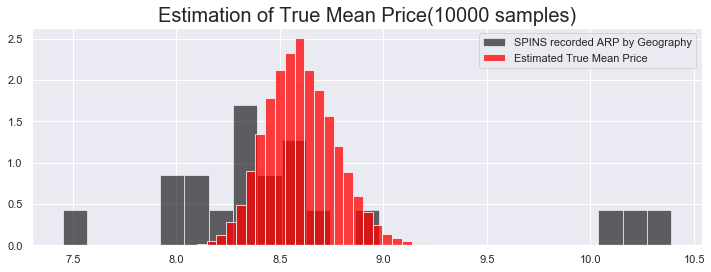

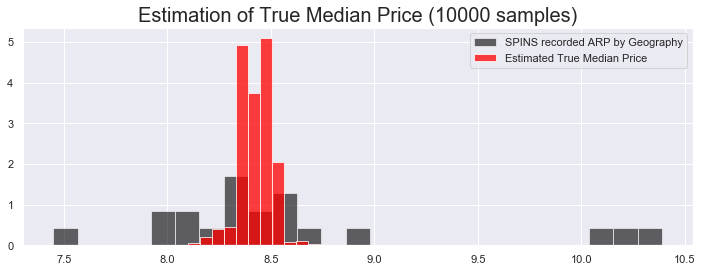

In [16]:
single_product_analysis(items[0])


In [ ]:
single_product_analysis(items[1])

In [ ]:
single_product_analysis(items[2])

In [ ]:
single_product_analysis(items[3])

In [ ]:
single_product_analysis(items[4])

In [ ]:
single_product_analysis(items[5])

In [ ]:
single_product_analysis(items[6])

In [ ]:
single_product_analysis(items[7])

In [ ]:
single_product_analysis(items[8])

In [ ]:
single_product_analysis(items[9])

In [ ]:
single_product_analysis(items[10])

In [ ]:
single_product_analysis(items[11])

In [ ]:
single_product_analysis(items[12])

In [ ]:
single_product_analysis(items[13])

In [ ]:
single_product_analysis(items[14])

In [ ]:
single_product_analysis(items[15])

In [ ]:
single_product_analysis(items[16])

In [ ]:
single_product_analysis(items[17])

In [ ]:
single_product_analysis(items[18])

In [ ]:
single_product_analysis(items[19])

In [ ]:
def make_plots(df,pie_frame):
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "box"}, {"type": "pie"}]],
    )

    fig.add_trace(go.Box( x=df.Metric, 
                         y=df.amount, 
                         boxpoints ="all",
                         hovertext = df["Geography"],
                         jitter =0.5,
                         boxmean = True, 
                         showlegend=False,
                       # hovertemplate = 'Geography: $%{geography}'
                        ), 
                  row=1, col=1)
    #adds a line to reprsentMSRP
    fig.add_trace(go.Scatter(x=['ARP', 'Base_ARP'], y=[get_MSRP(df.loc[0,"UPC"]),get_MSRP(df.loc[0,"UPC"])],
                             mode="lines", name="MSRP", line=dict(color="#000000") ))
    
    #generates pie chart from calculated proportion data
    fig.add_trace(go.Pie(values=pie_frame["count"], labels =pie_frame["bins"], showlegend=True,
                         title_text ="Proportion MSRP Discounts"),
                  row=1, col=2)
    # Update xaxis properties
    fig.update_xaxes(title_text="Distribution of ARP vs Base ARP", row=1, col=1)
    #fig.update(title_text="Proportion of ARP as percentage discount",  row=1, col=2)

    fig.update_yaxes(title_text="Dollars", row=1, col=1)
    #fig.update_yaxes(title_text="Proportion of ARP as percentage discount",  row=1, col=2)

    #label the plot
    fig.update_layout(title_text=df["Item"][0], height=600)
    fig.update_layout(height=600, showlegend=True)

    fig.show()

In [ ]:
hovertemplate =
    '<i>Price</i>: $%{y:.2f}

In [ ]:
len(items)

In [ ]:
# ''''df2 = pd.read_csv("/Users/GuntherUlvanget/country_life/country_life_spins/Sprouts_INFRA_24 weeks_ending_7_12_20.csv", 
#                      sep = ",", na_values = "-",
#                  usecols= [  'Geography', 'Item_UPC', 'Brand', 'Subcategory',
#        'AGE', 'FORM', 'FUNCTIONAL_INGREDIENT', 'FLAVOR', 'HEALTH_FOCUS',
#        'Group', 'SIZE', 'Dollars', 'Dollars_Yago', 'Units', 'Units_Yago', 'Dollars_SPP', 'ARP',
#        'ARP_Yago',  'Base_ARP',
#        'Base_ARP_Yago'])
       
#        #df3 = process_data("/Users/GuntherUlvanget/country_life/country_life_spins/Sprouts_INFRA_24 weeks_ending_7_12_20.csv")'''

#df["ARP_percent_off_MSRP"] = df["ARP"].apply(lambda x: (1-(x/get_MSRP("2474"))))
#mag_df.head()
                                                      

#mag_df2 = sku_selcetor_ingredient("mag",df)
#mag_df3 = sku_singleton('2474', df)
#mag_df3.head()

#df["ARP_percent_off_MSRP"] =  df["ARP"].apply(lambda x: (1-(x/get_MSRP("2474")))*100)
#df['bins'] = pd.cut(df['ARP_percent_off_MSRP'],bins=[0,5,10,15,20,25,30,35,40], labels=["0-5%","5-10%","10-15%","15-20%","20-25%","25-30%", "30-35%","35-40"])


#mag_df3.reset_index(inplace = True)

#mag_df3.loc[:,"ARP_percent_off_MSRP"] = (1-(mag_df3["ARP"]/get_MSRP("2474"))) *100

#mag_df3['bins'] = pd.cut(mag_df3['ARP_percent_off_MSRP'],bins=[0,5,10,15,20,25,30,35,40], labels=["0-5%","5-10%","10-15%","15-20%","20-25%","25-30%", "30-35%","35-40"])
# ax = sns.boxplot(x='Metric', y='amount', data=mag_df3, showfliers = False)
# ax = sns.stripplot(x='Metric', y='amount', data=mag_df3, color = "black", jitter = .1 )
# ax.axhline(cl_top_seller["MSRP$"][0])
# #plt.title(mag_df3["Item"][0])
#mag_df3 = mag_df3.melt(id_vars=["UPC", "Item","Geography",'Brand', 'Subcategory'], var_name = "Metric" , value_name='amount')
# cl_top_seller.loc[0,]
# fig = px.box(mag_df3, x="Metric", y="amount", points="all", title = mag_df3["Item"][0])
# fig.add_trace(go.Scatter(x=['ARP', 'Base_ARP'], y=[get_MSRP("2474"),get_MSRP("2474")], mode="lines", name="MSRP"))
# fig.show()
# mag_df3["Metric"].unique()
# mag_df3 = mag_df3.loc[mag_df3["Metric"].isin(metric_to_use)].reset_index()
# boot_strap_sample.plot_boot_strap_metric(single_sku_df["ARP"].to_numpy())
# boot_strap_sample.plot_boot_strap_metric(single_sku_df["ARP"].to_numpy(), test_statistic=np.median)
# pie = px.pie(data_frame= c,
#             names = "bins"
#             , values = "count",
#             title = "Breakdown of ARP as a percentage off MSRP")

# pie.show()

# pie.title.position 

In [ ]:
# conn = psycopg2.connect("user='postgres' host='localhost'")

# cur = conn.cursor()

# conn.autocommit = True
# cur.execute('DROP DATABASE IF EXISTS spins;')
# cur.execute('CREATE DATABASE spins;')

# cur.close() # This is optional
# conn.close() # Closing the connection also closes all cursors

# conn = psycopg2.connect("dbname='spins' user='postgres' host='localhost'")

# cur = conn.cursor()

#  # Inside insulinpricing database create a table with all of the 
#     #appropriate column names to match with the CSV file header. '
# query = '''
       
# CREATE TABLE spins_data(Geography VARCHAR, 
# Item_UPC, 
# Brand, 
# Subcategory,
# AGE, 
# FORM, 
# FUNCTIONAL_INGREDIENT, 
# FLAVOR, 
# HEALTH_FOCUS,
# Group, 
# SIZE, 
# Dollars, 
# Dollars_Yago, 
# Units, 
# Units_Yago, 
# Dollars_SPP, 
# ARP,
# ARP_Yago,  
# Base_ARP,
# Base_ARP_Yago)



# (NDC_Description VARCHAR ,NDC VARCHAR, 
#     NADAC_Per_Unit NUMERIC, Effective_Date DATE,
#     Pricing_Unit VARCHAR,Pharmacy_Type_Indicator VARCHAR,
#     OTC VARCHAR,Explanation_Code VARCHAR,
#     Classification_for_Rate_Setting VARCHAR,
#     Corresponding_Generic_Drug_NADAC_Per_Unit NUMERIC,
#     Corresponding_Generic_Drug_Effective_Date DATE,
#     As_of_Date DATE);
#         '''
# cur.execute(query)